In [12]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.layers import Dense, Embedding, Input, Add, Dot, Reshape, Flatten
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.sequence import skipgrams
from tensorflow.python.keras.models import Model, load_model
import sklearn
import array
import pickle
import tarfile
from urllib.request import urlretrieve
import os
import sys
from os import listdir
import nltk
from os.path import isfile, join
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np
from scipy.sparse import save_npz, load_npz
from tensorflow.python.keras import backend as K
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils import plot_model
import pandas as pd
import scipy
%matplotlib inline

In [2]:
def getTextFromCooc(pathToFile):
    with open(pathToFile, 'r', encoding='utf8') as f:
        indexRow = 0
        headerText = []
        docs = []
        for row in f:
            if(indexRow == 0):
                for word in row.split(','):
                    headerText.append(word)
            else:
                indexNumber = 0
                isStringCreated = False
                for word2 in row.split(','):
                    if(indexNumber == 0):
                        pass
                    else:
                        if int(word2) == 1:
                            if(isStringCreated == False):
                                string = ''
                                isStringCreated = True
                            if(string == ""):
                                string = headerText[indexNumber-1]
                            else:
                                string = string +' '+headerText[indexNumber-1]
                    indexNumber += 1
                #string = string[2:]
                docs.append(string)
                docs = [s.replace("'", '"') for s in docs] # remove all the 8s 
            indexRow +=1
    with open('./docs/textTheGoodScents.txt','wb') as f:
        pickle.dump(docs, f)
    return [docs,headerText]

In [3]:
docs,headerText = getTextFromCooc('./Oniris/data.csv')
headerText = headerText[1:]
print(len(headerText))
print(headerText)

54
['"à noyaux"', '"agrumes"', '"alcool"', '"aldehyde"', '"amande amère"', '"amylique"', '"animal"', '"anise"', '"autre"', '"beurre"', '"boise"', '"caramel"', '"champignon"', '"chimique"', '"cuir"', '"doux"', '"empyreumatique"', '"epice"', '"fermentaire"', '"floral"', '"fruite"', '"fruits à pépins"', '"fruits cuits"', '"fruits exotiques"', '"fruits jaunes"', '"fruits noirs"', '"fruits rouges"', '"fruits secs"', '"fumé"', '"géranium"', '"inconnu"', '"lactique"', '"lactone"', '"légumes cuits"', '"levure"', '"malte"', '"menthe"', '"métallique"', '"mineral"', '"moisi-terreux"', '"noyau de cerise"', '"pharmaceutique"', '"pieds"', '"pomme de terre"', '"pyrazique"', '"rose"', '"soufre"', '"thiol vegetal"', '"vanille"', '"vegetal sec"', '"vegetal vert"', '"vinaigre"', '"violette"', '"vomi"\n']


In [4]:
v_size = len(headerText)
tokenizer = Tokenizer(num_words=v_size, oov_token='UNK')
tokenizer.fit_on_texts(docs)

In [50]:
generate_cooc = False
def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    sequences = tokenizer.texts_to_sequences(text)
    meanLen = 0
    meanNumber = 0
    for sequence in sequences:
        meanLen += len(sequence)
        meanNumber +=1
    meanLen = meanLen/meanNumber
    window_size = round(meanLen)
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    for sequence in sequences:
        window_size = int(len(sequence)/2)
        if(len(sequence) % 2 == 0):
            print(sequence[window_size-1:-window_size])
            print("window_size")
            print(window_size)
            print(sequence)
            print("ca bug iciiiii")
            print(np.arange(window_size, len(sequence)-window_size+1))
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size+1), sequence[window_size-1:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                print("Context window")
                print(context_window)
                distances = np.abs(np.arange(-(window_size-1), window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2,), dtype=np.float32)
                nom[window_size-1] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    print("wi :")
                    print(wi)
                    print("i :")
                    print(i)
                    print("nom : ")
                    print(nom)
                    cooc_mat[wi, context_window] += nom
        else:
            print(sequence[window_size-1:-window_size])
            print("window_size")
            print(window_size)
            print(sequence)
            print(np.arange(window_size, len(sequence)-window_size))
            for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
                context_window = sequence[i-window_size: i+window_size+1]
                print("Context window")
                print(context_window)
                distances = np.abs(np.arange(-window_size, window_size+1))
                distances[window_size] = 1.0
                nom = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
                nom[window_size] = 0.0
                if use_weighting:
                    cooc_mat[wi, context_window] += nom/distances    # Update element
                else:
                    print("wi :")
                    print(wi)
                    print("i :")
                    print(i)
                    print("nom : ")
                    print(nom)
                    cooc_mat[wi, context_window] += nom
    
    return cooc_mat    

if not generate_cooc:
    cooc_mat = generate_cooc_matrix(docs, tokenizer, 4, v_size, False)
    print("Generated......")
    cooc_mat
    save_npz(os.path.join('datasets','cooc_mat.npz'), cooc_mat.tocsr())
else:
    cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz')).tolil()
    print('Cooc matrix of type {} was loaded from disk'.format(type(cooc_mat).__name__))
    
print(cooc_mat)

[45]
window_size
2
[2, 45, 10, 8]
ca bug iciiiii
[2]
Context window
[2, 45, 10, 8]
wi :
45
i :
2
nom : 
[1. 0. 1. 1.]
[11]
window_size
4
[29, 24, 18, 11, 20, 53, 3, 19]
ca bug iciiiii
[4]
Context window
[29, 24, 18, 11, 20, 53, 3, 19]
wi :
11
i :
4
nom : 
[1. 1. 1. 0. 1. 1. 1. 1.]
[11, 4]
window_size
5
[13, 37, 38, 7, 11, 4, 20, 2, 31, 14, 10]
[5]
Context window
[13, 37, 38, 7, 11, 4, 20, 2, 31, 14, 10]
wi :
4
i :
5
nom : 
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[22, 4]
window_size
3
[18, 9, 22, 4, 10, 46, 53]
[3]
Context window
[18, 9, 22, 4, 10, 46, 53]
wi :
4
i :
3
nom : 
[1. 1. 1. 0. 1. 1. 1.]
[9, 4]
window_size
5
[37, 38, 18, 5, 9, 4, 20, 2, 31, 6, 3]
[5]
Context window
[37, 38, 18, 5, 9, 4, 20, 2, 31, 6, 3]
wi :
4
i :
5
nom : 
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[31, 14]
window_size
5
[12, 5, 11, 2, 31, 14, 32, 33, 25, 6, 3]
[5]
Context window
[12, 5, 11, 2, 31, 14, 32, 33, 25, 6, 3]
wi :
14
i :
5
nom : 
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
[33]
window_size
6
[13, 12, 23, 5, 47, 33, 53, 

In [57]:
print(docs[0])

"fruits jaunes" "mineral" "vanille"


13
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[ 2  3  4  5  6  7  8  9 10 11 52 12 14 15 16 17 18 19 20 21 22 23 24 13
 53]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


([<matplotlib.axis.XTick at 0x17ab5dd77b8>,
 <a list of 25 Text xticklabel objects>)

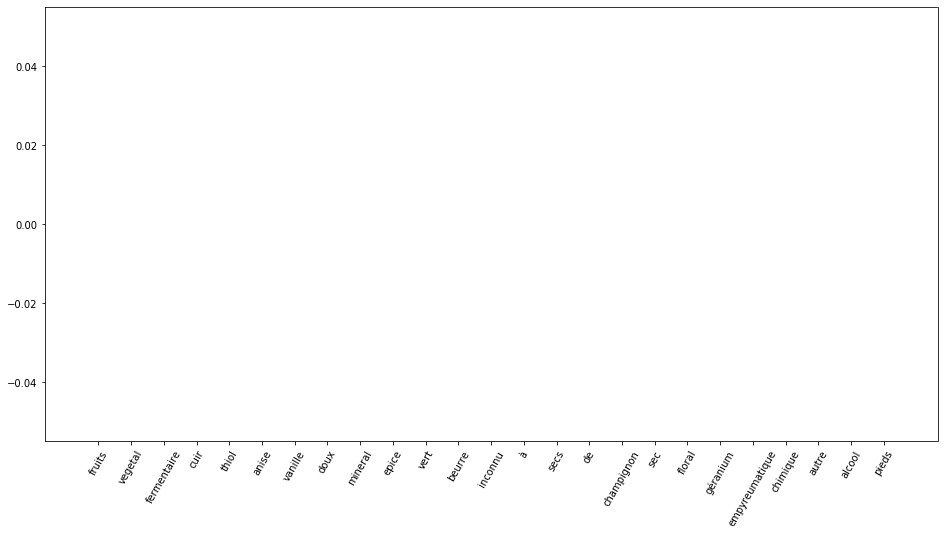

In [51]:
def create_glove_model(v_size):    
    w_i = Input(shape=(1,))
    w_j = Input(shape=(1,))

    emb_i = Flatten()(Embedding(v_size, 96, input_length=1)(w_i))
    emb_j = Flatten()(Embedding(v_size, 96, input_length=1)(w_j))

    ij_dot = Dot(axes=-1)([emb_i,emb_j])
    
    b_i = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_i)
    )
    b_j = Flatten()(
        Embedding(v_size, 1, input_length=1)(w_j)
    )

    pred = Add()([ij_dot, b_i, b_j])

    def glove_loss(y_true, y_pred):
        return K.sum(
            K.pow((y_true-1)/100.0, 0.75)*K.square(y_pred - K.log(y_true))
        )

    model = Model(inputs=[w_i, w_j],outputs=pred)
    model.compile(loss=glove_loss, optimizer =Adam(lr=0.0001))
    return model


In [52]:
K.clear_session()
model = create_glove_model(v_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 96)        5184        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 96)        5184        input_2[0][0]                    
______________________________________________________________________________________________

In [53]:
cooc_mat = load_npz(os.path.join('datasets','cooc_mat.npz'))
batch_size =128
copy_docs = list(docs)
index2word = dict(zip(tokenizer.word_index.values(), tokenizer.word_index.keys()))
""" Each epoch """
for ep in range(10):
    
    #valid_words = get_valid_words(docs, 20, tokenizer)
    
    random.shuffle(copy_docs)
    losses = []
    """ Each document (i.e. movie plot) """
    for doc in copy_docs:
        
        seq = tokenizer.texts_to_sequences([doc])[0]

        """ Getting skip-gram data """
        # Negative samples are automatically sampled by tf loss function
        wpairs, labels = skipgrams(
            sequence=seq, vocabulary_size=v_size, negative_samples=0.0, shuffle=True
        )
        
        if len(wpairs)==0:
            continue

        sg_in, sg_out = zip(*wpairs)
        sg_in, sg_out = np.array(sg_in).reshape(-1,1), np.array(sg_out).reshape(-1,1)
        x_ij = np.array(cooc_mat[sg_in[:,0], sg_out[:,0]]).reshape(-1,1) + 1
        
        assert np.all(np.array(labels)==1)
        assert x_ij.shape[0] == sg_in.shape[0], 'X_ij {} shape does not sg_in {}'.format(x_ij.shape, sg_in.shape)
        """ For each batch in the dataset """
        model.fit([sg_in, sg_out], x_ij, batch_size = batch_size, epochs=1, verbose=0)
        l = model.evaluate([sg_in, sg_out], x_ij, batch_size=batch_size, verbose=0)
        losses.append(l)
    print('Loss in epoch {}: {}'.format(ep, np.mean(losses)))

D:\IDE\Anaconda\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Loss in epoch 0: 1.1166778337739791
Loss in epoch 1: 1.0988600657006609
Loss in epoch 2: 1.076149157391357
Loss in epoch 3: 1.0554503494329948
Loss in epoch 4: 1.027870350126222
Loss in epoch 5: 1.0038718493515615
Loss in epoch 6: 0.9749729801287897
Loss in epoch 7: 0.9421190799749569
Loss in epoch 8: 0.9119055223535646
Loss in epoch 9: 0.8779565374321253


In [54]:
def save_embeddings(model,save_dir, tok, v_size):
    """ Saving data to disk """
    
    # We need to add the 0th index to word list manually
    word_list = ["RESERVED"]+[tok.index_word[w_i] for w_i in range(1,v_size)]
    emb_w_df = None
    for layer in model.layers:
        if 'embedding' == layer.name or 'embedding_1' == layer.name:
            if emb_w_df is None:
                emb_w_df = pd.DataFrame(layer.get_weights()[0])
            else:
                emb_w_df += layer.get_weights()[0]
    
    emb_w_df.insert(0, "word", word_list)
            
    emb_w_df.to_csv(
        os.path.join(save_dir, 'embeddings_w_Oniris.csv'), index=False, header=None
    )
    
save_embeddings(model, 'datasets', tokenizer, v_size)
model.save('glove_model_Oniris.h5')

RuntimeError: Unable to create link (name already exists)

In [55]:

def get_valid_words(docs, size, tok):
    """ Get a random set of words to check the embeddings """
    np.random.seed(120)
    valid_docs = np.random.choice(docs, size=size//2)
    valid_words = []
    for doc in valid_docs:
        np.random.seed(100)
        words = np.random.choice(tok.texts_to_sequences([doc])[0],size=2)
        valid_words.extend(words)
        
    return valid_words
        
valid_words = get_valid_words(docs, 10, tokenizer)
def load_embeddings(filename):
    print('Loading the word embeddings from the disk')
    embed_df = pd.read_csv(filename, index_col=False, header=None)
    embed_df = embed_df.set_index(0)
    print('Embedding shape: {}'.format(embed_df.shape))
    embed_mat = embed_df.values
    words = embed_df.index.values
    return embed_mat, words

def get_cosine_sim(emb, valid_words, top_k):
    norm = np.sqrt(np.sum(emb**2,axis=1,keepdims=True))
    norm_emb = emb/norm
    in_emb = norm_emb[valid_words,:]
    similarity = np.dot(in_emb, np.transpose(norm_emb))
    sorted_ind = np.argsort(-similarity, axis=1)[:,1:top_k+1]
    return sorted_ind, valid_words

embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w_Oniris.csv'))
print(embed_mat)
print(words)
best_ids, wids = get_cosine_sim(embed_mat, valid_words, 5)
pd.Series(words).to_csv(os.path.join('datasets','index2word_Oniris.csv'))
for w, bi in zip(wids, best_ids):
    print("{}: {}".format(words[w], ', '.join(words[bii] for bii in bi)))
    

Loading the word embeddings from the disk
Embedding shape: (54, 96)
[[ 0.05020254 -0.05837529 -0.0403703  ... -0.04685563  0.04568789
   0.00139977]
 [ 0.06225527  0.01959495  0.00575552 ...  0.08022629  0.08815909
   0.08500276]
 [-0.02414489  0.08817861  0.0287921  ...  0.06505247  0.03204026
   0.00814258]
 ...
 [ 0.05612282  0.06836951 -0.03463638 ... -0.02962888  0.04324662
   0.04643132]
 [ 0.00020501  0.0134081  -0.01320745 ... -0.03459857 -0.05716103
   0.01210265]
 [-0.03455864 -0.04144376 -0.04793806 ...  0.01575217 -0.04263462
  -0.09005082]]
['RESERVED' 'UNK' 'fruits' 'vegetal' 'fermentaire' 'cuir' 'thiol' 'anise'
 'vanille' 'doux' 'mineral' 'epice' 'beurre' 'alcool' 'inconnu' 'à' 'secs'
 'de' 'champignon' 'sec' 'floral' 'géranium' 'empyreumatique' 'chimique'
 'autre' 'rose' 'cuits' 'noyau' 'cerise' 'agrumes' 'lactone' 'noirs'
 'levure' 'métallique' 'noyaux' 'animal' 'malte' 'amande' 'amère'
 'exotiques' 'boise' 'soufre' 'amylique' 'caramel' 'vinaigre' 'jaunes'
 'pharmaceut

D:\IDE\Anaconda\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


Loading the word embeddings from the disk
Embedding shape: (54, 96)
[[1.11022302e-16 1.03416704e+00 1.11844505e+00 ... 9.90912407e-01
  9.98689975e-01 8.89953223e-01]
 [1.03416704e+00 2.22044605e-16 5.60649219e-01 ... 8.63520724e-01
  8.77301308e-01 9.02434262e-01]
 [1.11844505e+00 5.60649219e-01 4.44089210e-16 ... 1.03237745e+00
  9.46786124e-01 1.01051746e+00]
 ...
 [9.90912407e-01 8.63520724e-01 1.03237745e+00 ... 1.11022302e-16
  7.55736494e-01 1.03755478e+00]
 [9.98689975e-01 8.77301308e-01 9.46786124e-01 ... 7.55736494e-01
  2.22044605e-16 1.18172755e+00]
 [8.89953223e-01 9.02434262e-01 1.01051746e+00 ... 1.03755478e+00
  1.18172755e+00 0.00000000e+00]]
(54, 54)
[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 54 samples in 0.000s...
[t-SNE] Computed neighbors for 54 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 54 / 54
[t-SNE] Mean sigma: 0.235507
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 62.7338943, 

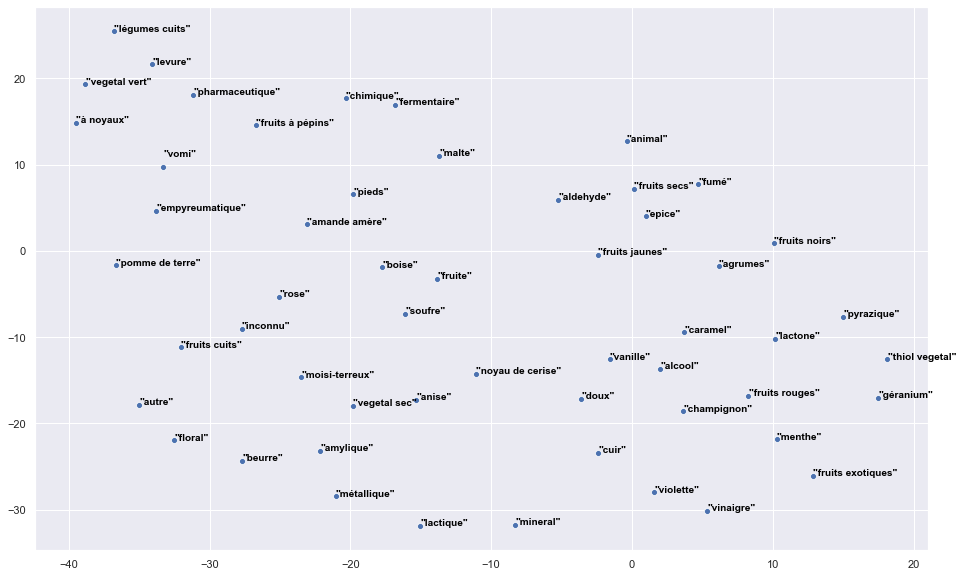

In [37]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import pairwise_distances
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)
def getCosineMatrix(emb):
    matrix = pairwise_distances(emb,emb, metric='cosine', n_jobs=-1)
    return matrix
embed_mat, words = load_embeddings(os.path.join('datasets','embeddings_w_Oniris.csv'))
cosine_matrix = getCosineMatrix(embed_mat)
print(cosine_matrix)
print(cosine_matrix.shape)

tsne = TSNE(n_components=2,metric='precomputed',verbose=2,n_iter = 2000,perplexity=12)
X_embedded = tsne.fit_transform(cosine_matrix)

X_embedded.shape

df_subset = {} 
df_subset['tsne-2d-one'] = X_embedded[:,0]
df_subset['tsne-2d-two'] = X_embedded[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette=palette)
for line in range(0,embed_mat.shape[0]):
     p1.text(df_subset['tsne-2d-one'][line]+0.01, df_subset['tsne-2d-two'][line], 
     headerText[line], horizontalalignment='left', 
     size='small', color='black', weight='semibold')

